### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("cardio.csv", sep=';', index_col='id')
df.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
mask = ((df.ap_hi<250)&(df.ap_lo<250)&(df.ap_hi>50)&(df.ap_lo>10)&(df.height>100)).values

In [5]:
df = df[mask]

In [6]:
df['bmi'] = df.weight/(df.height/100)**2
df['gender'] = df.gender-1
df['age'] = df.age//365
df['hi_gluc'] = (df.gluc-1).replace({2:1})
df['hi_cholesterol'] = (df.cholesterol-1).replace({2:1})
# df.drop(['gluc', 'cholesterol', 'height', 'weight'], axis=1, inplace=True)

In [7]:
target = df.pop('cardio')

In [8]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=13)

In [9]:
continuos_cols = ['age', 'ap_hi', 'ap_lo', 'bmi']
# cat_cols = ['cholesterol', 'gluc']
base_cols = ['gender', 'smoke', 'alco', 'active', 'hi_gluc', 'hi_cholesterol']

transfomer =  Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
cat_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                ('ohe', OneHotEncoder())
            ])
    
base_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value=0, ))
            ])
    
preprocesser = ColumnTransformer(transformers=[
    ('numeric',transfomer,continuos_cols),
#     ('category',cat_transformer,cat_cols),
    ('base',base_transformer,base_cols)
])

In [10]:
X_train_transformed = pd.DataFrame(preprocesser.fit_transform(X_train), columns=continuos_cols+base_cols)
X_test_transformed = pd.DataFrame(preprocesser.transform(X_test), columns=continuos_cols+base_cols)
X_train_transformed.head(3)

,age,ap_hi,ap_lo,bmi,gender,smoke,alco,active,hi_gluc,hi_cholesterol
0,-1.156023,-0.396518,-0.139863,-0.753317,1.0,0.0,0.0,1.0,0.0,0.0
1,1.501958,1.393772,0.885809,0.343542,1.0,0.0,0.0,1.0,0.0,0.0
2,1.058961,-0.396518,-0.139863,-0.431638,1.0,0.0,0.0,1.0,1.0,1.0


In [11]:
model = Pipeline([
    ('preprocess', preprocesser),
    ('clf', RandomForestClassifier(max_depth = 5, n_estimators = 50, random_state=13))])
model.fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model[-1])
shap_values = np.array(explainer.shap_values(model[0].transform(X_test)))

In [12]:
from sklearn.metrics import precision_recall_curve, roc_auc_score

def evaluate_results(y_test, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]:.4f}\n')
    print('Classification results:')
    f1 = fscore[ix]
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_probs)
    print("roc: %.2f%%" % (roc * 100.0)) 
    prc = precision[ix]
    print("precision: %.2f%%" % (prc * 100.0)) 
    rec = recall[ix]
    print("recall: %.2f%%" % (rec * 100.0)) 

y_probs = model.predict_proba(X_test)[:,1]    
evaluate_results(y_test, y_probs)

Best Threshold=0.3865

Classification results:
f1: 73.33%
roc: 78.77%
precision: 67.15%
recall: 80.78%


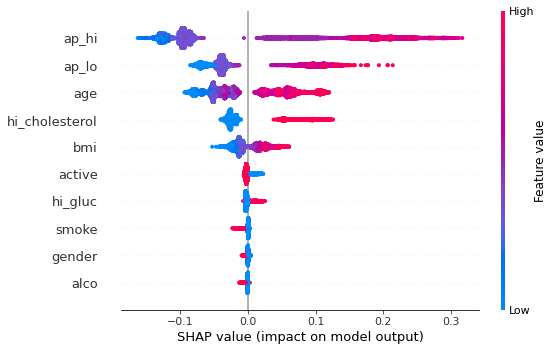

In [13]:
X_test_transformed = pd.DataFrame(model[0].transform(X_test), columns=continuos_cols+base_cols)

# summarize the effects of all the features
shap.summary_plot(shap_values[1], X_test_transformed)

Для топ 10% распределение следующее:

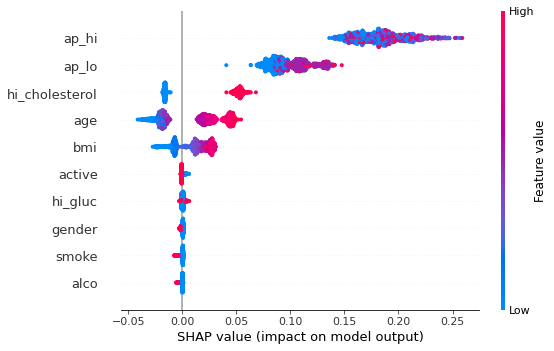

In [14]:
idx_top = np.argsort(y_probs)[-int(y_probs.shape[0]*0.1):]

# summarize the effects of all the features
shap.summary_plot(shap_values[1][idx_top], X_test_transformed.iloc[idx_top])

У людей с сердечно-сосудистыми заболеваниями:
* высокое артериальное давление (как верхнее, так и нижнее)
* они старше
* имеют более высокий индекс массы тела (возможно, лишний вес)
* активность, уровень сахара, факт курения или употребления алкоголя, а также пол, в целом не так сильно связаны с фактором заболевания.

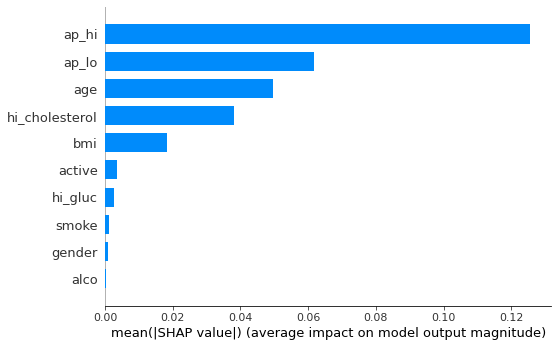

In [15]:
shap.summary_plot(shap_values[1], X_train_transformed, plot_type="bar")

Вышеупомянутое (но уже в разрезе модели) видно и на этом графике.

Посмотрим на примере одного испытуемого, под номером 1234.

In [16]:
X_test.iloc[1234]

age                53.000000
gender              0.000000
height            158.000000
weight             70.000000
ap_hi             130.000000
ap_lo              90.000000
cholesterol         1.000000
gluc                1.000000
smoke               0.000000
alco                0.000000
active              1.000000
bmi                28.040378
hi_gluc             0.000000
hi_cholesterol      0.000000
Name: 92769, dtype: float64

In [17]:
y_test.iloc[1234]

0

In [18]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[1], shap_values[1][1234], X_test_transformed.columns)

Хотя согласно нашему датасету, испытуемый здоров, у него налицо проблемы с давлением и с весом. Он пока недостаточно стар и у него нет проблем с холестирином, может быть дело в этом. Но наша модель этим признакам отводит меньшее значение, чем давлению. Сойдемся на том, что он находится в группе риска.